# SMS Spam classification with Naive Bayes.

- Libraries
- Exploring the Dataset
- Distribution spam and non-spam plots
- Text Analytics
- Feature Engineering
- Predictive analysis (Multinomial Naive Bayes)
- Conclusion


## Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn import feature_extraction, model_selection, naive_bayes, metrics, svm
from IPython.display import Image
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

## Exploring the Dataset

In [2]:
data = pd.read_csv('../input/spam.csv', encoding='latin-1')
data.head(n=10)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
5,spam,FreeMsg Hey there darling it's been 3 week's n...,NaN,NaN,NaN
6,ham,Even my brother is not like to speak with me. ...,NaN,NaN,NaN
7,ham,As per your request 'Melle Melle (Oru Minnamin...,NaN,NaN,NaN
8,spam,WINNER!! As a valued network customer you have...,NaN,NaN,NaN
9,spam,Had your mobile 11 months or more? U R entitle...,NaN,NaN,NaN


## Distribution spam/non-spam plots

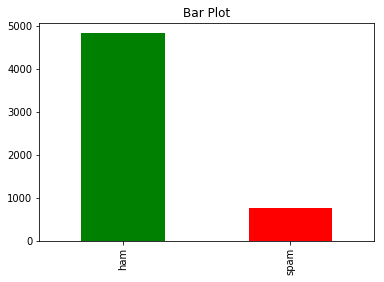

In [3]:
count_Class=pd.value_counts(data["v1"], sort= True)
count_Class.plot(kind = 'bar',color = ["green","red"])
plt.title('Bar Plot')
plt.show();

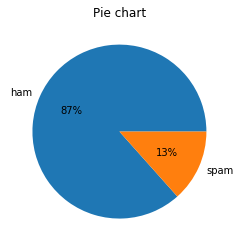

In [4]:
count_Class.plot(kind = 'pie',autopct='%1.0f%%')
plt.title('Pie chart')
plt.ylabel('')
plt.show()

## Text Analytics

We want to find the frequencies of words in the spam and non-spam messages. The words of the messages will be model features.

We use the function Counter.

In [5]:
count1 = Counter(" ".join(data[data['v1']=='ham']["v2"]).split()).most_common(20)
df1 = pd.DataFrame.from_dict(count1)
df1 = df1.rename(columns={0: "words in non-spam", 1 : "count"})
count2 = Counter(" ".join(data[data['v1']=='spam']["v2"]).split()).most_common(20)
df2 = pd.DataFrame.from_dict(count2)
df2 = df2.rename(columns={0: "words in spam", 1 : "count_"})

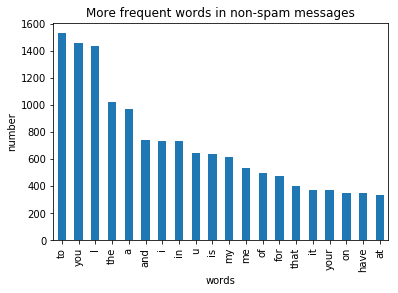

In [6]:
df1.plot.bar(legend = False)
y_pos = np.arange(len(df1["words in non-spam"]))
plt.xticks(y_pos, df1["words in non-spam"])
plt.title('More frequent words in non-spam messages')
plt.xlabel('words')
plt.ylabel('number')
plt.show()

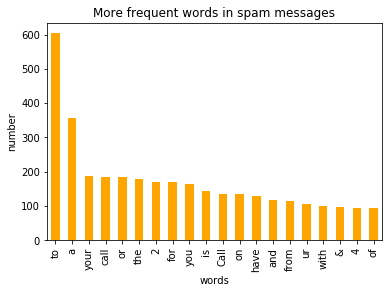

In [7]:
df2.plot.bar(legend = False, color = 'orange')
y_pos = np.arange(len(df2["words in spam"]))
plt.xticks(y_pos, df2["words in spam"])
plt.title('More frequent words in spam messages')
plt.xlabel('words')
plt.ylabel('number')
plt.show()

We can see that the majority of frequent words in both classes are stop words such as 'to', 'a', 'or' and so on.

With stop words we refer to the most common words in a lenguage, there is no simgle, universal list of stop words.

## Feature engineering

Text preprocessing, tokenizing and filtering of stopwords are included in a high level component that is able to build a dictionary of features and transform documents to feature vectors.

**We remove the stop words in order to improve the analytics**

In [8]:
f = feature_extraction.text.TfidfVectorizer(stop_words = 'english')
X = f.fit_transform(data["v2"])
np.shape(X)

(5572, 8404)

We have created more than 8400 new features. The new feature j in the row i is equal to 1 if the word wj appears in the text example i . It is zero if not.

## Predictive Analysis

My goal is to predict if a new sms is spam or non-spam. I assume that is much worse misclassify non-spam than misclassify an spam. (I don't want to have false positives)

The reason is because I normally don't check the spam messages.

The two possible situations are:

- New spam sms in my inbox. (False negative).

  OUTCOME: I delete it.

- New non-spam sms in my spam folder (False positive).
    
    OUTCOME: I probably don't read it.

I prefer the first option!!!

First we transform the variable spam/non-spam into binary variable, then we split our data set in training set and test set.

In [9]:
data["v1"]=data["v1"].map({'spam':1,'ham':0})
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, data['v1'], test_size=0.33, random_state=42)
print([np.shape(X_train), np.shape(X_test)])

[(3733, 8404), (1839, 8404)]


## Multinomial naive bayes classifier

We train different bayes models changing the regularization parameter α .

We evaluate the accuracy, recall and precision of the model with the test set.

In [10]:
list_alpha = np.arange(1/100000, 20, 0.11)
score_train = np.zeros(len(list_alpha))
score_test = np.zeros(len(list_alpha))
recall_test = np.zeros(len(list_alpha))
precision_test= np.zeros(len(list_alpha))
count = 0
for alpha in list_alpha:
    bayes = naive_bayes.MultinomialNB(alpha=alpha)
    bayes.fit(X_train, y_train)
    score_train[count] = bayes.score(X_train, y_train)
    score_test[count]= bayes.score(X_test, y_test)
    recall_test[count] = metrics.recall_score(y_test, bayes.predict(X_test))
    precision_test[count] = metrics.precision_score(y_test, bayes.predict(X_test))
    count = count + 1

Let's see the first 10 learning models and their metrics

In [11]:
matrix = np.matrix(np.c_[list_alpha, score_train, score_test, recall_test, precision_test])
models = pd.DataFrame(data = matrix, columns = 
             ['alpha', 'Train Accuracy', 'Test Accuracy', 'Test Recall', 'Test Precision'])
models.head(n=10)

,alpha,Train Accuracy,Test Accuracy,Test Recall,Test Precision
0,0.00001,1.000000,0.973355,0.912698,0.894942
1,0.11001,0.998661,0.978249,0.920635,0.920635
2,0.22001,0.997589,0.981512,0.900794,0.961864
3,0.33001,0.994910,0.981512,0.888889,0.973913
4,0.44001,0.993571,0.978793,0.857143,0.986301
5,0.55001,0.992231,0.976074,0.829365,0.995238
6,0.66001,0.989821,0.976074,0.825397,1.000000
7,0.77001,0.985534,0.973355,0.805556,1.000000
8,0.88001,0.981248,0.968461,0.769841,1.000000
9,0.99001,0.978034,0.965742,0.750000,1.000000


I select the model with the most test precision

In [12]:
best_index = models['Test Precision'].idxmax()

In [13]:
models.iloc[best_index, :]

alpha             0.660010
Train Accuracy    0.989821
Test Accuracy     0.976074
Test Recall       0.825397
Test Precision    1.000000
Name: 6, dtype: float64

**My best model does not produce any false positive, which is our goal.**

Let's see if there is more than one model with 100% precision !

In [14]:
models[models['Test Precision']==1].head(n=5)

,alpha,Train Accuracy,Test Accuracy,Test Recall,Test Precision
6,0.66001,0.989821,0.976074,0.825397,1.0
7,0.77001,0.985534,0.973355,0.805556,1.0
8,0.88001,0.981248,0.968461,0.769841,1.0
9,0.99001,0.978034,0.965742,0.750000,1.0
10,1.10001,0.975355,0.963567,0.734127,1.0


Between these models with the highest possible precision, we are going to select which has more test accuracy.

In [15]:
best_index = models[models['Test Precision']==1]['Test Accuracy'].idxmax()
bayes = naive_bayes.MultinomialNB(alpha=list_alpha[best_index])
bayes.fit(X_train, y_train)
models.iloc[best_index, :]

alpha             0.660010
Train Accuracy    0.989821
Test Accuracy     0.976074
Test Recall       0.825397
Test Precision    1.000000
Name: 6, dtype: float64

Confusion matrix with naive bayes classifier

In [16]:
m_confusion_test = metrics.confusion_matrix(y_test, bayes.predict(X_test))
pd.DataFrame(data = m_confusion_test, columns = ['Predicted 0', 'Predicted 1'],
            index = ['Actual 0', 'Actual 1'])

,Predicted 0,Predicted 1
Actual 0,1587,0
Actual 1,44,208


We misclassify 44 spam messages as non-spam emails whereas we don't misclassify any non-spam message.

## Finalize Model

In [17]:
from _pickle import dump
filename = 'finalized_model.sav'
dump(bayes, open(filename, 'wb'))

## Conclusion

The best model I have found is Naive Bayes with 98% accuracy.

It classifies every non-spam message correctly (Model precision)

It classifies the 82.5% of spam messages correctly (Model recall)

github - https://github.com/ahkhalwai/SMS_Spam_Detection